# Homework Assignment 3 - Chem 277B
## Breast Cancer Prediction

### 1) Objective

We found in the last HW assignment that many features of the Breast Cancer Wisconsin dataset are highly correlated.
Analyze the Breast Cancer Wisconsin dataset using dimensionality reduction and classification techniques (Naive Bayes) to predict whether a tumor is benign or malignant. Compare the results to your earlier findings.

### 2) Preparation

Before starting, import the necessary libraries for data analysis and visualization. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

Load the dataset from `sklearn`, which contains cell descriptors and a target variable (diagnosis: 0 = malignant, 1 = benign).

In [2]:
data, target = load_breast_cancer(return_X_y=True, as_frame=True)
feature_names = data.columns

Split the dataset into training (50%) and testing (50%) sets this time. Use `random_state=42` for reproducibility. Scale the features to a range of [0, 1] using `MinMaxScaler`.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.50, random_state=42)

######## Fill in the code below ########

# scale train and test data
scaler   = MinMaxScaler(feature_range = (0, 1)) 
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# build a map to avoid converting back to DataFrame
column_map = {name: idx for idx, name in enumerate(X_train.columns)}

########################################

print(f'Shape of training features: {X_train.shape}')
print(f'Shape of training labels: {y_train.shape}')
print(f'Shape of test features: {X_test.shape}')
print(f'Shape of test labels: {y_test.shape}')

Shape of training features: (284, 30)
Shape of training labels: (284,)
Shape of test features: (285, 30)
Shape of test labels: (285,)


### 3) Baseline results

Use the *mean radius* (the first feature) to build a Gaussian Naive Bayes classifier. Evaluate the classifier on the test set and display the confusion matrix. The results should be not as good as the result from the previous homework assignment due to the reduced training set size.

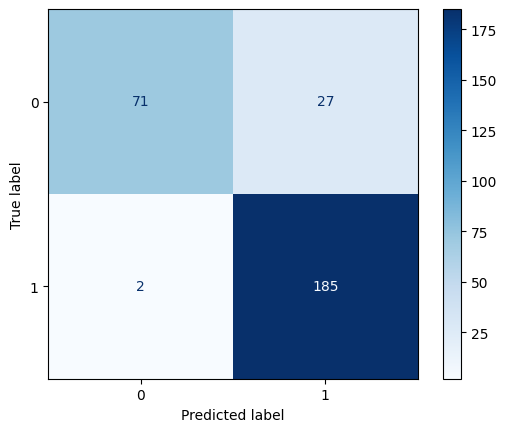

In [4]:
######## Fill in the code below ########

# our target features
features = ["mean radius"]  
indices = [column_map[name] for name in features]

X_train_selected = X_train_scaled[:, indices]
X_test_selected = X_test_scaled[:, indices]

# Chew, chew... I'm a train!
gnb = GaussianNB()
Fit = gnb.fit(X_train_selected, y_train)

# predict our classes
y_pred = Fit.predict(X_test_selected)
proba = Fit.predict_proba(X_test_selected)

########################################

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [5]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# classification report
print("\nClassification Report (mean radius):")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

# extract individual metrics for malignant class (label = 1)
malignant_precision = precision_score(y_test, y_pred, pos_label=1)
malignant_recall    = recall_score(y_test, y_pred, pos_label=1)
malignant_f1        = f1_score(y_test, y_pred, pos_label=1)

print(f"\nMalignant Class Metrics:")
print(f"Precision: {malignant_precision:.2f}")
print(f"Recall:    {malignant_recall:.2f}")
print(f"F1 Score:  {malignant_f1:.2f}")


Classification Report (mean radius):
              precision    recall  f1-score   support

      Benign       0.97      0.72      0.83        98
   Malignant       0.87      0.99      0.93       187

    accuracy                           0.90       285
   macro avg       0.92      0.86      0.88       285
weighted avg       0.91      0.90      0.89       285


Malignant Class Metrics:
Precision: 0.87
Recall:    0.99
F1 Score:  0.93


In [6]:
import seaborn as sns

'''
# with 30 features...
# ...this is very slow
out = sns.pairplot(data, kind = "kde", \
                   plot_kws = {'color':[176/255,224/255,230/255]}, \
                   diag_kws = {'color':'black'})
out.map_offdiag(plt.scatter, color = 'black')
plt.show()
''';

### 4) Principal Component Analysis

#### 4.1) PCA on training set

Perform PCA on the **training set** to reduce the dimensionality. Plot the **full** eigenvalue spectrum (use log scale for the y-axis). How many principal components are needed to explain at least 90% of the variance in the data?

In [7]:
#display(data.columns)
#data.mean()
#data.var()

print("We note that our varibles have vastly different variences.")

We note that our varibles have vastly different variences.


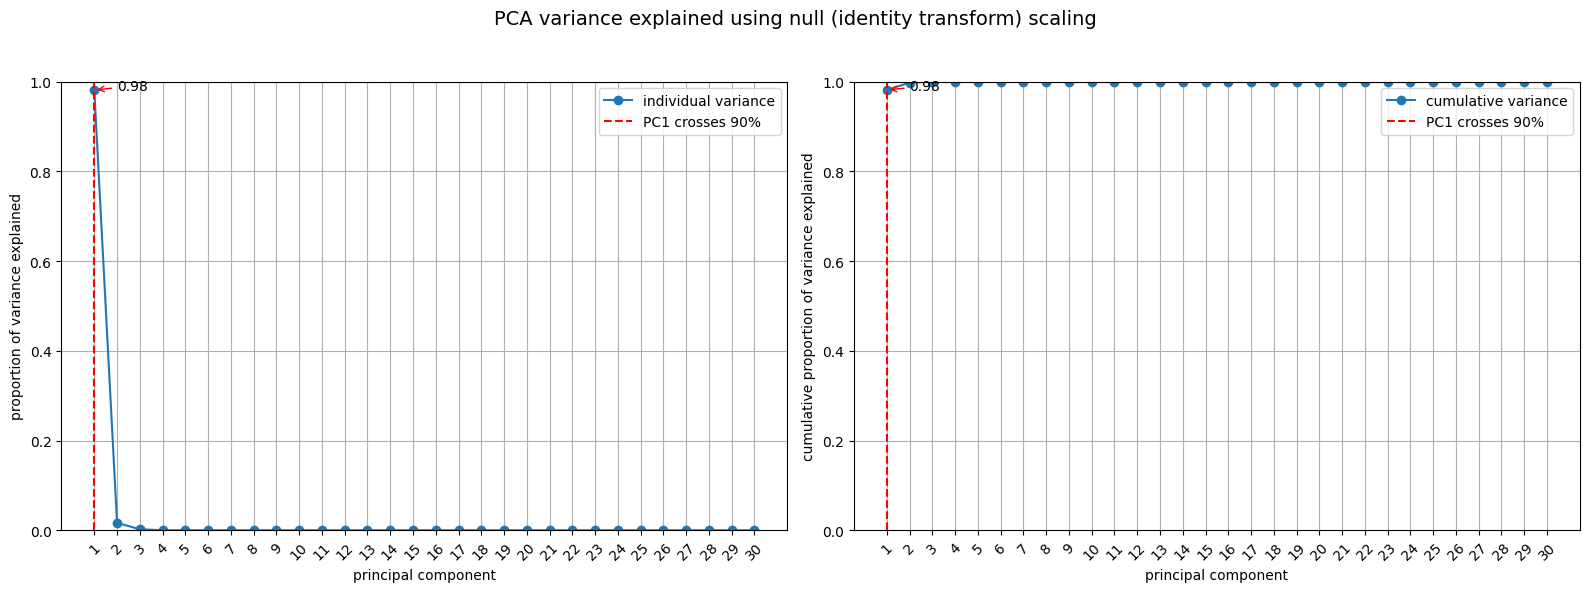

null (identity transform)
  number of components to exceed 90% variance: 1
  variance explained by PC1: 0.9810
  total variance explained by first 1 PCs: 0.9810



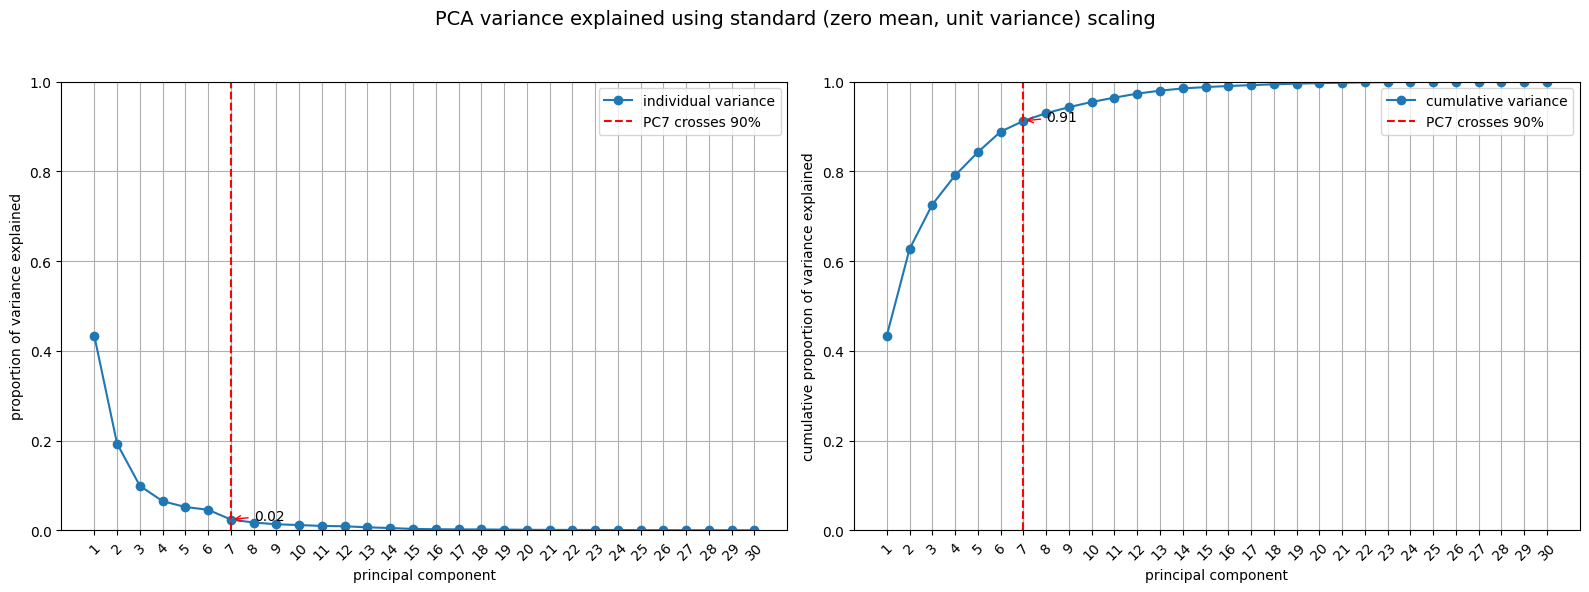

standard (zero mean, unit variance)
  number of components to exceed 90% variance: 7
  variance explained by PC7: 0.0239
  total variance explained by first 7 PCs: 0.9121



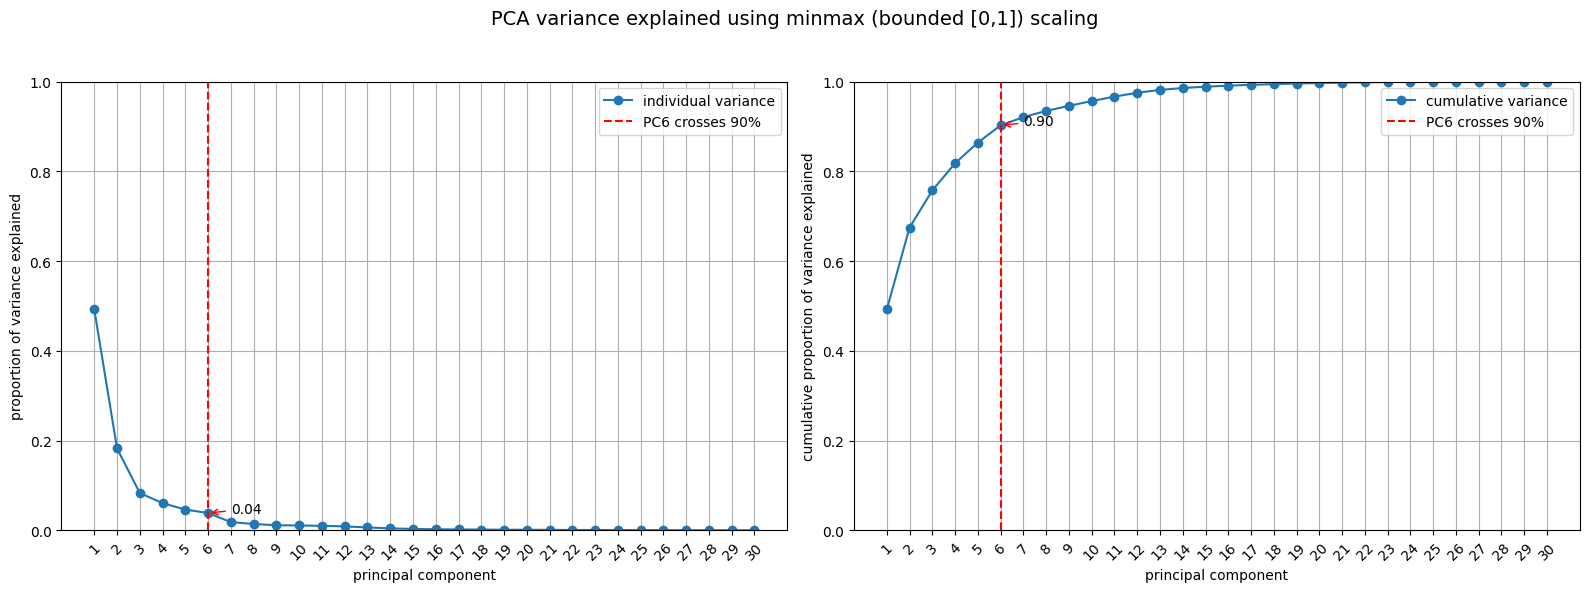

minmax (bounded [0,1])
  number of components to exceed 90% variance: 6
  variance explained by PC6: 0.0384
  total variance explained by first 6 PCs: 0.9023



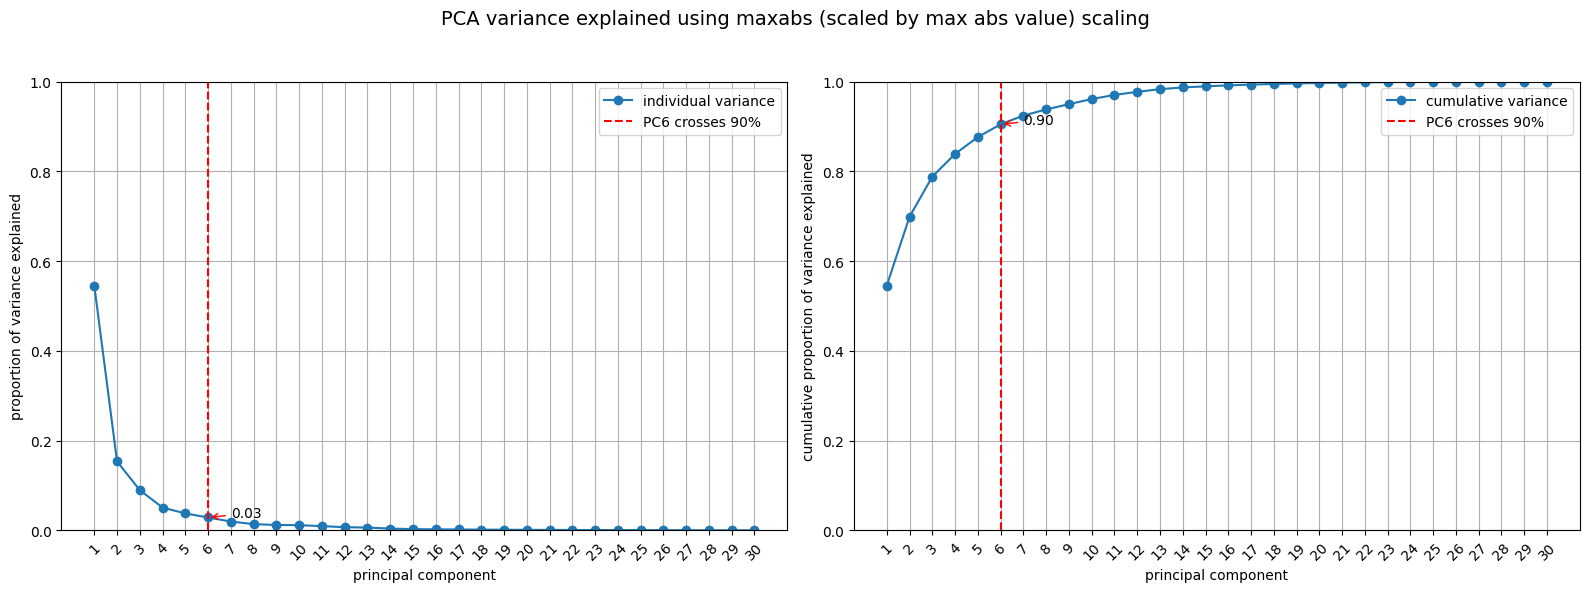

maxabs (scaled by max abs value)
  number of components to exceed 90% variance: 6
  variance explained by PC6: 0.0285
  total variance explained by first 6 PCs: 0.9046



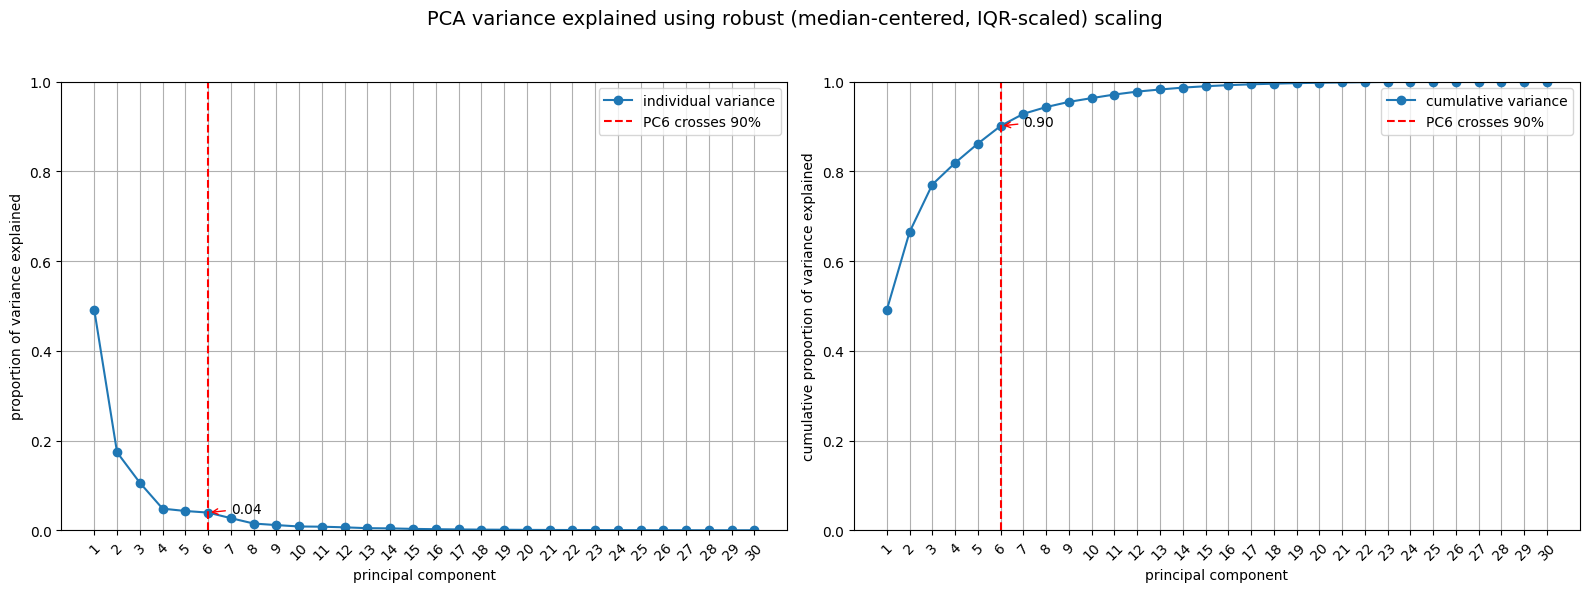

robust (median-centered, IQR-scaled)
  number of components to exceed 90% variance: 6
  variance explained by PC6: 0.0394
  total variance explained by first 6 PCs: 0.9010



In [8]:
######## Fill in the code below ########
# see also: 12.5 Lab: Unsupervised Learning
# in "An Introduction to Statistical Learning with Applicaitions in Python"
# by Hastie, et al (www.statlearning.com)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, RobustScaler, MaxAbsScaler
from sklearn.decomposition import PCA

# scalers under test (uncomment to explore others)
scalers = {
    "null (identity transform)": FunctionTransformer(lambda x: x), # no scaling applied
    "standard (zero mean, unit variance)": StandardScaler(), # vector space: centered and normalized
    "minmax (bounded [0,1])": MinMaxScaler(), # affine space: positive semi-definite
    "maxabs (scaled by max abs value)": MaxAbsScaler(), # preserves sparsity, scales to [-1,1]
    "robust (median-centered, IQR-scaled)": RobustScaler(
        with_centering=True, # no effect
        with_scaling=True,
        quantile_range=(30.0, 70.0),  # tuned to exceed MinMaxScaler (naughty information leaking)
        unit_variance=False  # no effect
        ), # resistant to outliers
}

for name, scaler in scalers.items():
    # apply scaler to train and test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # fit pca on scaled training data
    pca = PCA()
    pca.fit(X_train_scaled)
    scores = pca.transform(X_train_scaled)

    # collect our variance metrics
    variance_ratio = pca.explained_variance_ratio_
    cumsum = variance_ratio.cumsum()

    # find number of components needed to exceed 90% cumulative variance
    idx = np.argmax(cumsum > 0.90)
    n_components90 = idx + 1
    ratio = variance_ratio[idx]       # variance explained by the last PC in the set
    ratio_tot = cumsum[idx]           # total cumulative variance explained

    # plot variance explained
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ticks = np.arange(pca.n_components_) + 1

    # plot individual variance explained
    ax = axes[0]
    ax.plot(ticks, variance_ratio, marker='o', label='individual variance')
    ax.axvline(n_components90, color='red', linestyle='--', label=f'PC{n_components90} crosses 90%')
    ax.annotate(f'{ratio:.2f}', xy=(n_components90, ratio), xytext=(n_components90+1, ratio),
                arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)
    ax.set_xlabel('principal component')
    ax.set_ylabel('proportion of variance explained')
    ax.set_ylim([0, 1])
    ax.set_xticks(ticks)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid()
    ax.legend()

    # plot cumulative variance explained
    ax = axes[1]
    ax.plot(ticks, cumsum, marker='o', label='cumulative variance')
    ax.axvline(n_components90, color='red', linestyle='--', label=f'PC{n_components90} crosses 90%')
    ax.annotate(f'{ratio_tot:.2f}', xy=(n_components90, ratio_tot), xytext=(n_components90+1, ratio_tot),
                arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)
    ax.set_xlabel('principal component')
    ax.set_ylabel('cumulative proportion of variance explained')
    ax.set_ylim([0, 1])
    ax.set_xticks(ticks)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid()
    ax.legend()

    # title
    fig.suptitle(f"PCA variance explained using {name} scaling", fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # print report
    print(f"{name}")
    print(f'  number of components to exceed 90% variance: {n_components90}')
    print(f'  variance explained by PC{n_components90}: {ratio:.4f}')
    print(f'  total variance explained by first {n_components90} PCs: {ratio_tot:.4f}')
    print()


#### Discuss 4.1
We tested several scaling methods to explore how they affected the number of principal components needed to explain at least 90% of the variance in our data.

Using **no scaling**, we found that a single principal component captured 98% of the variance.
While this may seem efficient, our features have wildly different units and variances, so PCA disproportionately emphasized one dominant feature while others contributed very little.

With **MinMaxScaler(feature_range=(0, 1))**, 6 principal components were needed to explain 90% of the variance.
This method equalizes feature scales while preserving relative spacing, which can be advantageous when features are bounded or when nonlinear relationships matter.
It also enforces a positive semi-definite covariance matrix, ensuring all eigenvalues are non-negative and the decomposition remains stable, thus reducing numerical artifacts.

Using **StandardScaler (with_mean=True, with_std=True)**, we found that 7 principal components explained 91% of the variance.
StandardScaler centers each feature to zero mean and scales to unit variance, ensuring that variance is distributed more evenly across dimensions.
However, this scaler is sensitive to outliers, which can distort both the scale and the skew of features.
Nonetheless, StandardScaler preserves a canonical origin and linear closure, making it a theoretically sound prescaler praticalurly for PCA the relies on centered data and Euclidean geometry.

We continued to add other scaling methods...

Using **MaxAbsScaler()** preserved sparsity (scales to between -1,1) and 6 principal components were required to explain 90% of the variance.

Finally we used **RobustScaler()** (median-centered, IQR-scaled) and found 6 PCs were needed to explain 90% of the variance.
The RobustScaler scaler shows promise for data with outliners beyond the StandardScaler
That said, empirically RobustScaler (with `quantile_range=(30.0, 70.0)`) works well because it compress the middle 40% values which reduces the influence of mild outliers thus emphasize the core structure.

**In summary**, the number of PCs required to explain 90% of the variance depends on the scaling technique used (and outliners in this data), however for most scalers, **6 PCs** were needed to explain %90 of the variance. 

#### 4.2) Analyze PCA

Visualize the principal components. What are the loadings of the original features on PC1? Which features contribute most? Compare the PCA results with the correlation plot from the previous homework assignment.

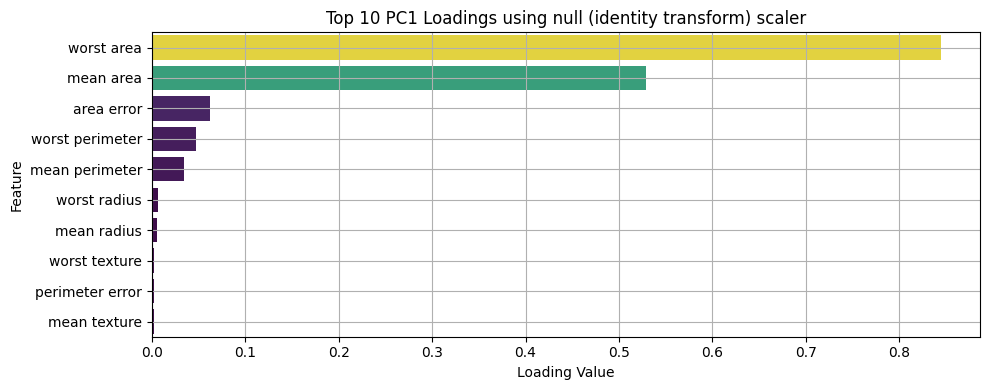


Top 10 PC1 loadings for null (identity transform):
            Feature  PC1 Loading  Abs Loading
23       worst area     0.844163     0.844163
3         mean area     0.529129     0.529129
13       area error     0.061976     0.061976
22  worst perimeter     0.047560     0.047560
2    mean perimeter     0.034912     0.034912
20     worst radius     0.006929     0.006929
0       mean radius     0.005074     0.005074
21    worst texture     0.002681     0.002681
12  perimeter error     0.002320     0.002320
1      mean texture     0.002087     0.002087


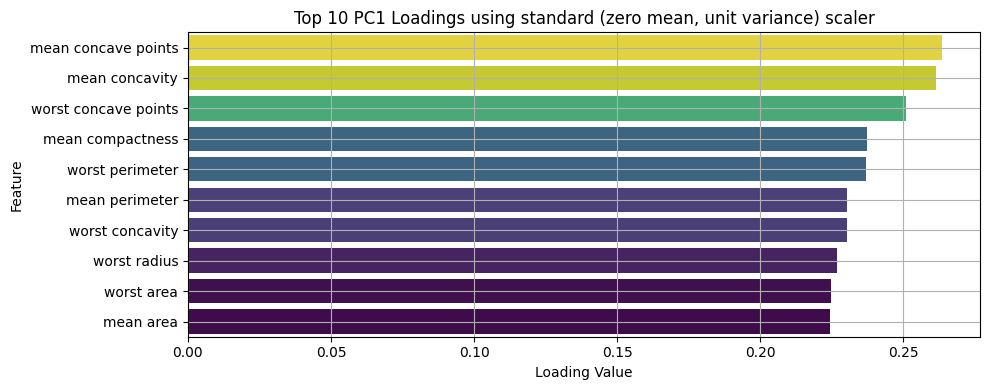


Top 10 PC1 loadings for standard (zero mean, unit variance):
                 Feature  PC1 Loading  Abs Loading
7    mean concave points     0.263595     0.263595
6         mean concavity     0.261507     0.261507
27  worst concave points     0.250822     0.250822
5       mean compactness     0.237159     0.237159
22       worst perimeter     0.237098     0.237098
2         mean perimeter     0.230447     0.230447
26       worst concavity     0.230336     0.230336
20          worst radius     0.226900     0.226900
23            worst area     0.224793     0.224793
3              mean area     0.224191     0.224191


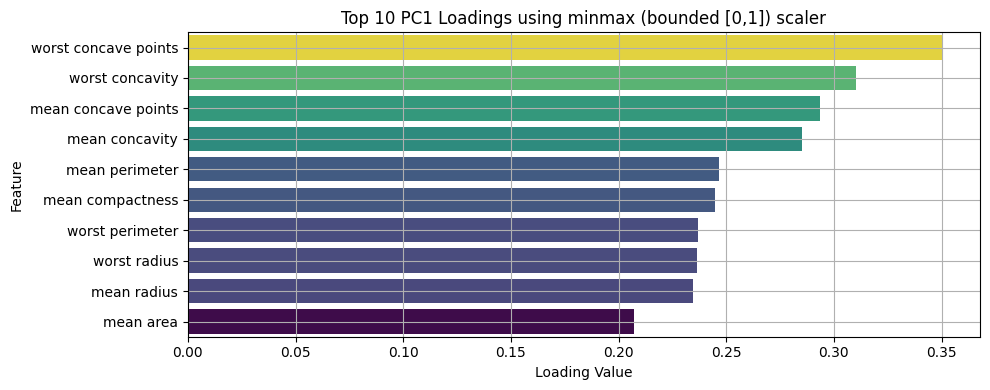


Top 10 PC1 loadings for minmax (bounded [0,1]):
                 Feature  PC1 Loading  Abs Loading
27  worst concave points     0.350319     0.350319
26       worst concavity     0.310077     0.310077
7    mean concave points     0.293661     0.293661
6         mean concavity     0.285222     0.285222
2         mean perimeter     0.246729     0.246729
5       mean compactness     0.244694     0.244694
22       worst perimeter     0.236877     0.236877
20          worst radius     0.236195     0.236195
0            mean radius     0.234593     0.234593
3              mean area     0.207296     0.207296


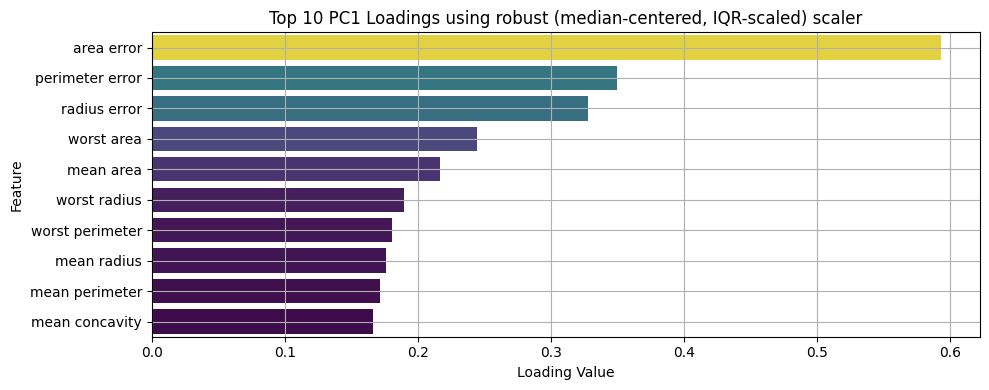


Top 10 PC1 loadings for robust (median-centered, IQR-scaled):
            Feature  PC1 Loading  Abs Loading
13       area error     0.592820     0.592820
12  perimeter error     0.349307     0.349307
10     radius error     0.327979     0.327979
23       worst area     0.244521     0.244521
3         mean area     0.216898     0.216898
20     worst radius     0.189203     0.189203
22  worst perimeter     0.180885     0.180885
0       mean radius     0.176016     0.176016
2    mean perimeter     0.171727     0.171727
6    mean concavity     0.165895     0.165895


In [9]:
# now let's make this pretty.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, RobustScaler, MaxAbsScaler
from sklearn.decomposition import PCA

# scalers under test (uncomment to explore others)
scalers = {
    "null (identity transform)": FunctionTransformer(lambda x: x), # no scaling applied
    "standard (zero mean, unit variance)": StandardScaler(), # vector space: centered and normalized
    "minmax (bounded [0,1])": MinMaxScaler(), # affine space: positive semi-definite
    # "maxabs (scaled by max abs value)": MaxAbsScaler() # preserves sparsity, scales to [-1,1]
    "robust (median-centered, IQR-scaled)": RobustScaler(
        with_centering=True, # no effect
        with_scaling=True,
        quantile_range=(30.0, 70.0),  # tuned to exceed MinMaxScaler (naughty information leaking)
        unit_variance=False  # no effect
    ), # resistant to outliers... think about this... does this increase outliner dominatince?
}

for name, scaler in scalers.items():
    # apply scaler to train and test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # fit pca on scaled training data
    pca = PCA()
    pca.fit(X_train_scaled)
    scores = pca.transform(X_train_scaled)

    # extract PC1 loadings
    pc1_loadings = pca.components_[0]  # first row of components matrix
    feature_names = data.columns  # use original feature names

    # build dataframe of loadings
    pc1_df = pd.DataFrame({
        'Feature': feature_names,
        'PC1 Loading': pc1_loadings
    })
    pc1_df['Abs Loading'] = pc1_df['PC1 Loading'].abs()
    pc1_df_sorted = pc1_df.sort_values(by='Abs Loading', ascending=False)

    # plot loadings
    plt.figure(figsize=(10, 4))
    sns.barplot(
        x='PC1 Loading',
        y='Feature',
        hue='PC1 Loading',
        data=pc1_df_sorted.head(10),
        palette='viridis',
        legend=False
    )
    plt.title(f"Top 10 PC1 Loadings using {name} scaler")
    plt.xlabel("Loading Value")
    plt.ylabel("Feature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # report top 10 contributing features
    print(f"\nTop 10 PC1 loadings for {name}:")
    print(pc1_df_sorted.head(10))

Note: Which scaler we use effects our loadings. We are using RobustScaler().


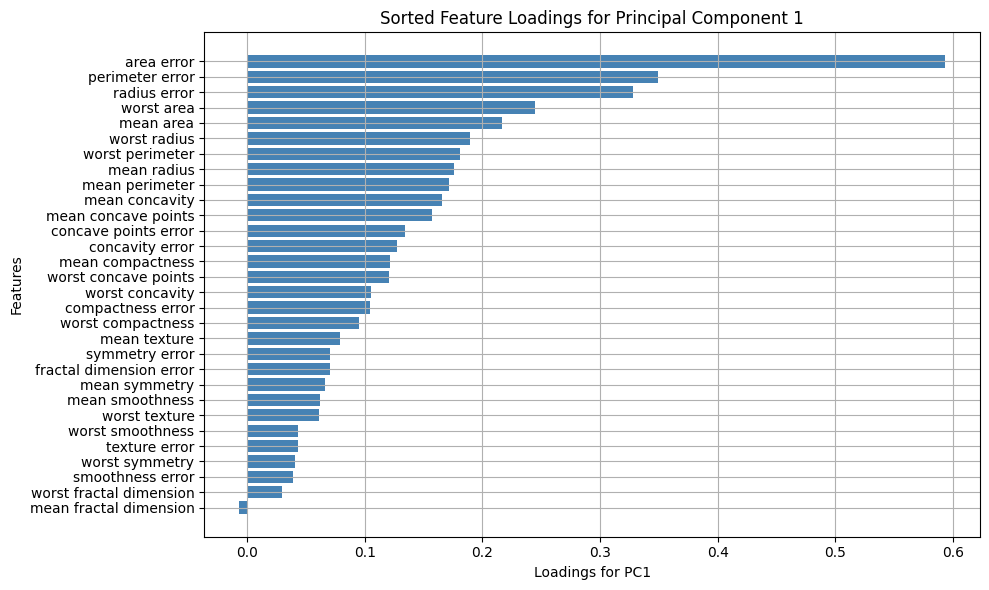

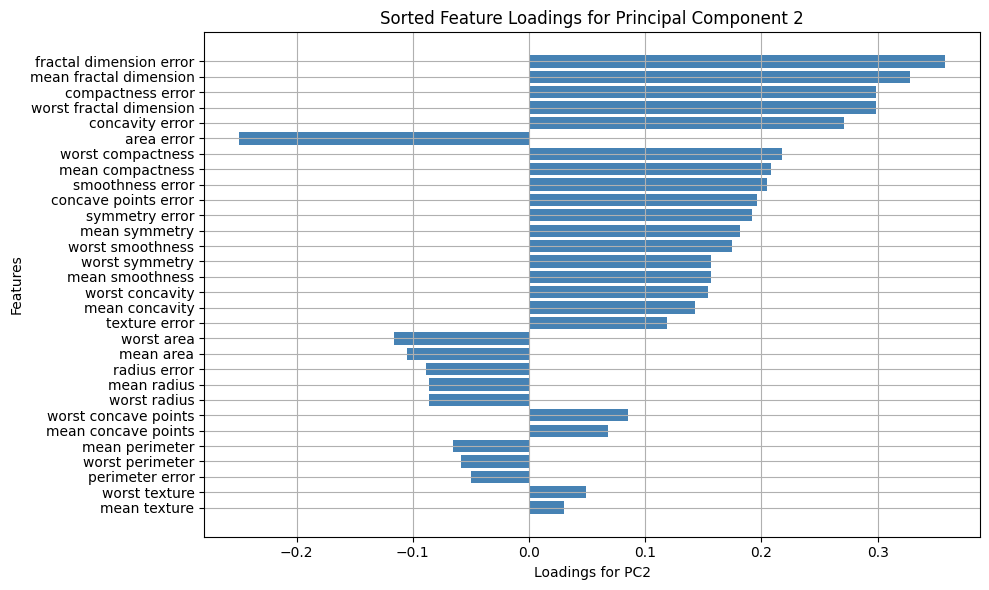

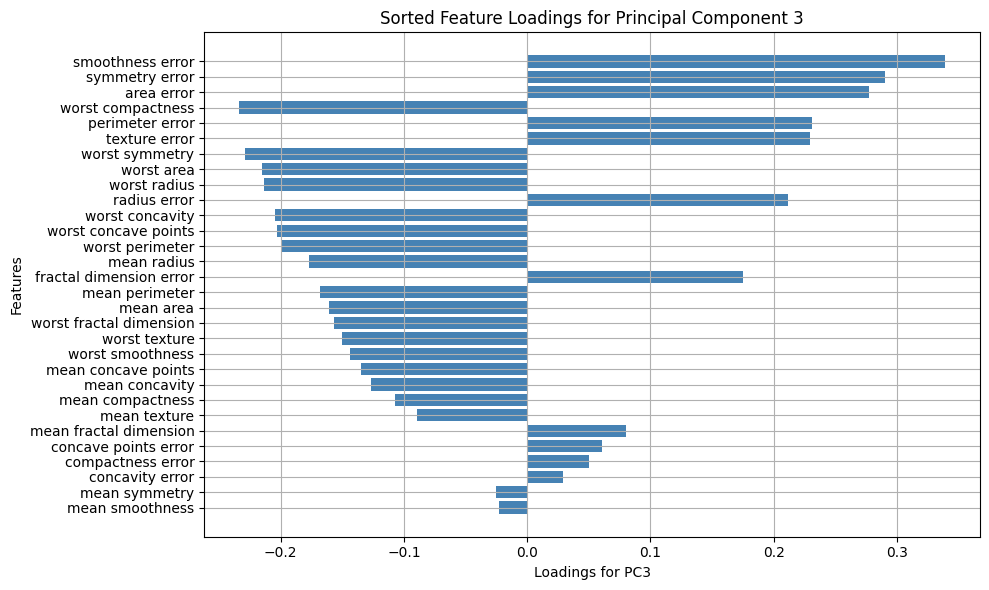

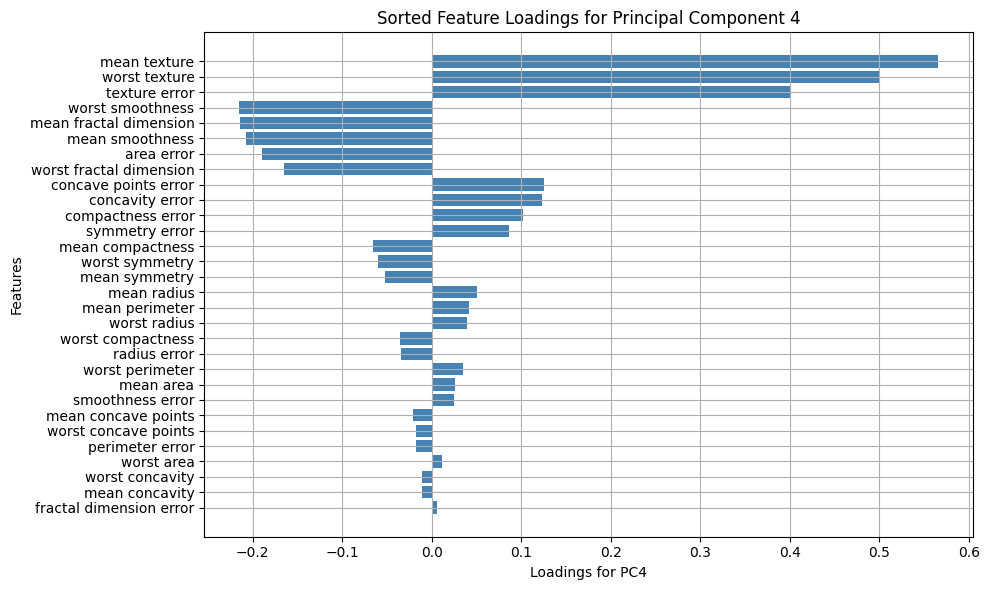

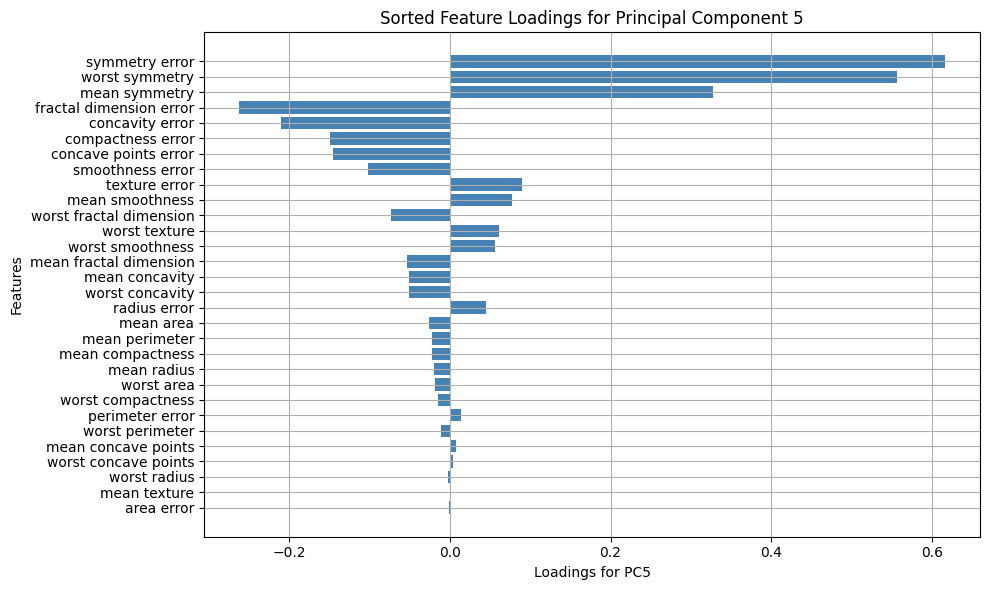

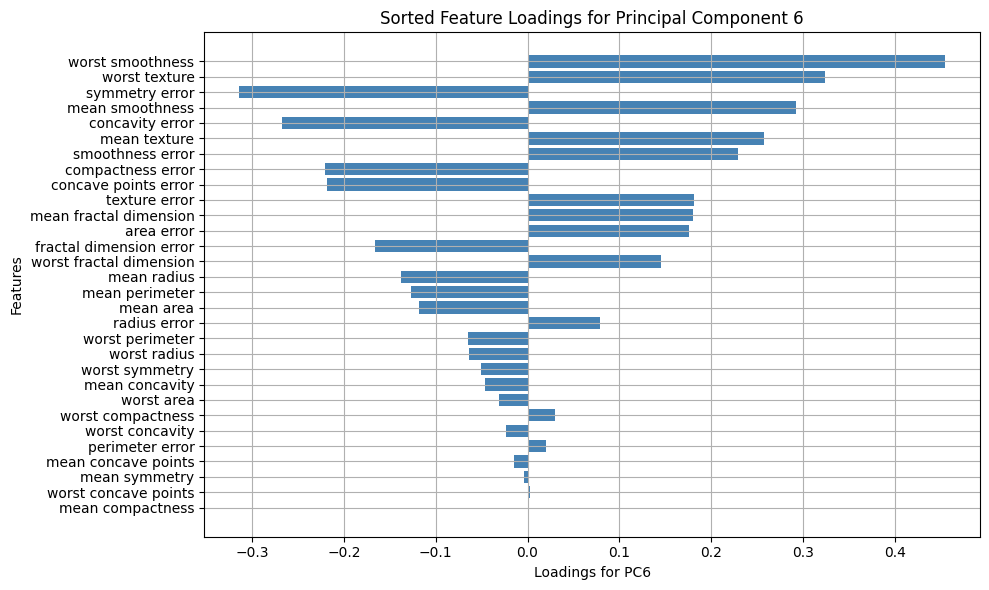

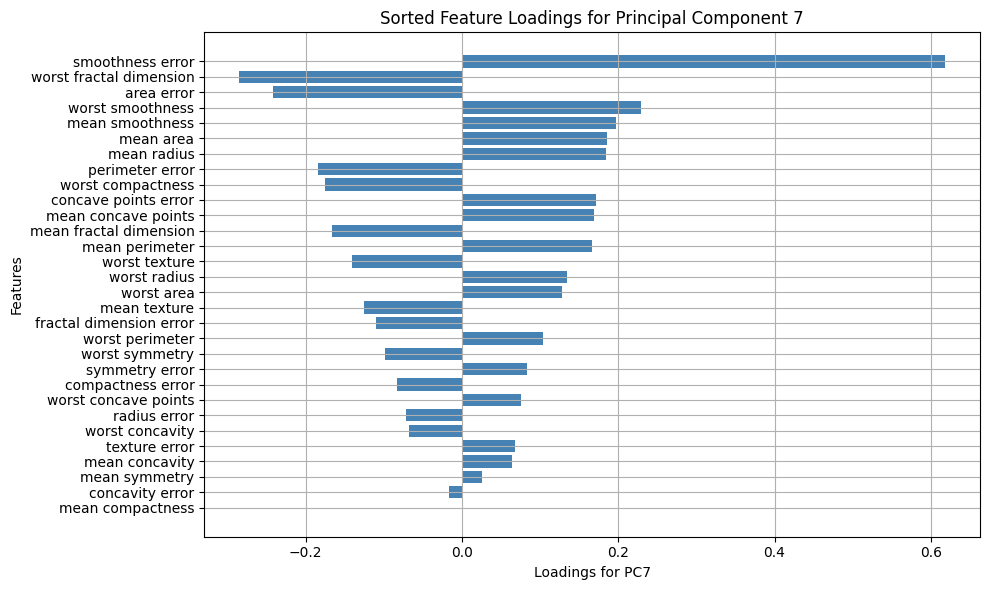

In [10]:
# I reject your reality and replace it with my own...
# FIXME!!! We are using whatever our last loading where... RobustScaler() in this case
# we ought to be more careful.
print("Note: Which scaler we use effects our loadings. We are using RobustScaler().")

n_components = 7

for i in range(n_components):
    plt.figure(figsize=(10, 6))

    # extract loadings for the i-th principal component
    pc_loadings = pca.components_[i]
    
    # build a dataframe for sorting
    loading_df = pd.DataFrame({
        'Feature': data.columns,
        f'PC{i+1} Loading': pc_loadings
    })
    loading_df['Abs Loading'] = loading_df[f'PC{i+1} Loading'].abs()
    loading_df_sorted = loading_df.sort_values(by='Abs Loading', ascending=True)

    # plot sorted loadings
    plt.barh(
        loading_df_sorted['Feature'],
        loading_df_sorted[f'PC{i+1} Loading'],
        color='steelblue'
    )
    plt.xlabel(f'Loadings for PC{i+1}')
    plt.ylabel('Features')
    plt.title(f'Sorted Feature Loadings for Principal Component {i+1}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Discuss 4.2

Honestly, the starter code and the problem statement are barely on speaking terms.
Hence, in true myth-busting fashion: I reject your reality and substitute my own.
We attempted to built a visualization that matches the problem statement, and hopefully provides some deeper insightful to...

It certainly is more fun this way! ;-)

*What are the loadings of the original features on PC1?*

As we noted above the loadings on PC1 depend on the scaler used.
See below for the top 10 loading for each scaler tested.

The loadings represent the weights of each original feature in the first principal component.
Features with larger absolute loadings contribute more to PC1.
In our case, shape descriptors (concavity, compactness, concave points) dominate, followed closely by geometric features (perimeter, radius, area).

*Which features contribute most?*

As we noted above the loadings on PC1 depend on the scaler used.
```
Top 10 PC1 loadings for minmax (bounded [0,1]):
                 Feature  PC1 Loading  Abs Loading
27  worst concave points     0.350319     0.350319
26       worst concavity     0.310077     0.310077
7    mean concave points     0.293661     0.293661
6         mean concavity     0.285222     0.285222
2         mean perimeter     0.246729     0.246729
5       mean compactness     0.244694     0.244694
22       worst perimeter     0.236877     0.236877
20          worst radius     0.236195     0.236195
0            mean radius     0.234593     0.234593
3              mean area     0.207296     0.207296

Top 10 PC1 loadings for standard (zero mean, unit variance):
                 Feature  PC1 Loading  Abs Loading
7    mean concave points     0.263595     0.263595
6         mean concavity     0.261507     0.261507
27  worst concave points     0.250822     0.250822
5       mean compactness     0.237159     0.237159
22       worst perimeter     0.237098     0.237098
2         mean perimeter     0.230447     0.230447
26       worst concavity     0.230336     0.230336
20          worst radius     0.226900     0.226900
23            worst area     0.224793     0.224793
3              mean area     0.224191     0.224191

Top 10 PC1 loadings for robust (median-centered, IQR-scaled):
            Feature  PC1 Loading  Abs Loading
13       area error     0.592820     0.592820
12  perimeter error     0.349307     0.349307
10     radius error     0.327979     0.327979
23       worst area     0.244521     0.244521
3         mean area     0.216898     0.216898
20     worst radius     0.189203     0.189203
22  worst perimeter     0.180885     0.180885
0       mean radius     0.176016     0.176016
2    mean perimeter     0.171727     0.171727
6    mean concavity     0.165895     0.165895
```

The following features are conserved for all scaling metheds shown here:
 - mean concavity
 - mean perimeter
 - mean area
 - worst perimeter
 - worst radius
   
These features appear to describe the shape complexity of the tumor.

Our experiments shows that using tuned RobustScaler pre-PCA and MixMaxScaler post-PCA has the best accuracy when used with the GaussianNB() model.
The PC1 loadings for this scaler show that error features contributed the most, as might be expected in measuring complex tumors.

*Compare the PCA results with the correlation plot from the previous homework assignment.*

From HW_02, we observed the strongest correlations among geometric features:
```
mean radius      mean perimeter     0.997855
worst radius     worst perimeter    0.993708
mean radius      mean area          0.987357
mean perimeter   mean area          0.986507
worst radius     worst area         0.984015
...
```

Also recall in HW_2 we found a strong correlation within feature catorgories such as geometric features, error terms, shape descriptors, and statistical metrics.
These reflected inherent geometric relationships: radius, perimeter, and area (which ought to scale together.)
We also saw clustering among shape descriptors like compactness, concavity, and concave points.

PCA appears to confirm this structure, where PC1 is driven by shape descriptors, all of which are which are tightly correlated.
Geometric features (radius, perimeter, area) also contributed, but to a lesser extent.
Thus correlation matrix and PCA loadings both reveal redundancy within feature categories and a latent structure across shape and size dimensions.

Things to think about:
 - latent morphological axis

### 4.3) Visualize each PC and Space

Visualize the **training data** with **each principal component** with a **histogram**, and the space defined by the first two principal components with a scatter plot. Color the points based on their class labels (malignant or benign). What patterns do you observe?

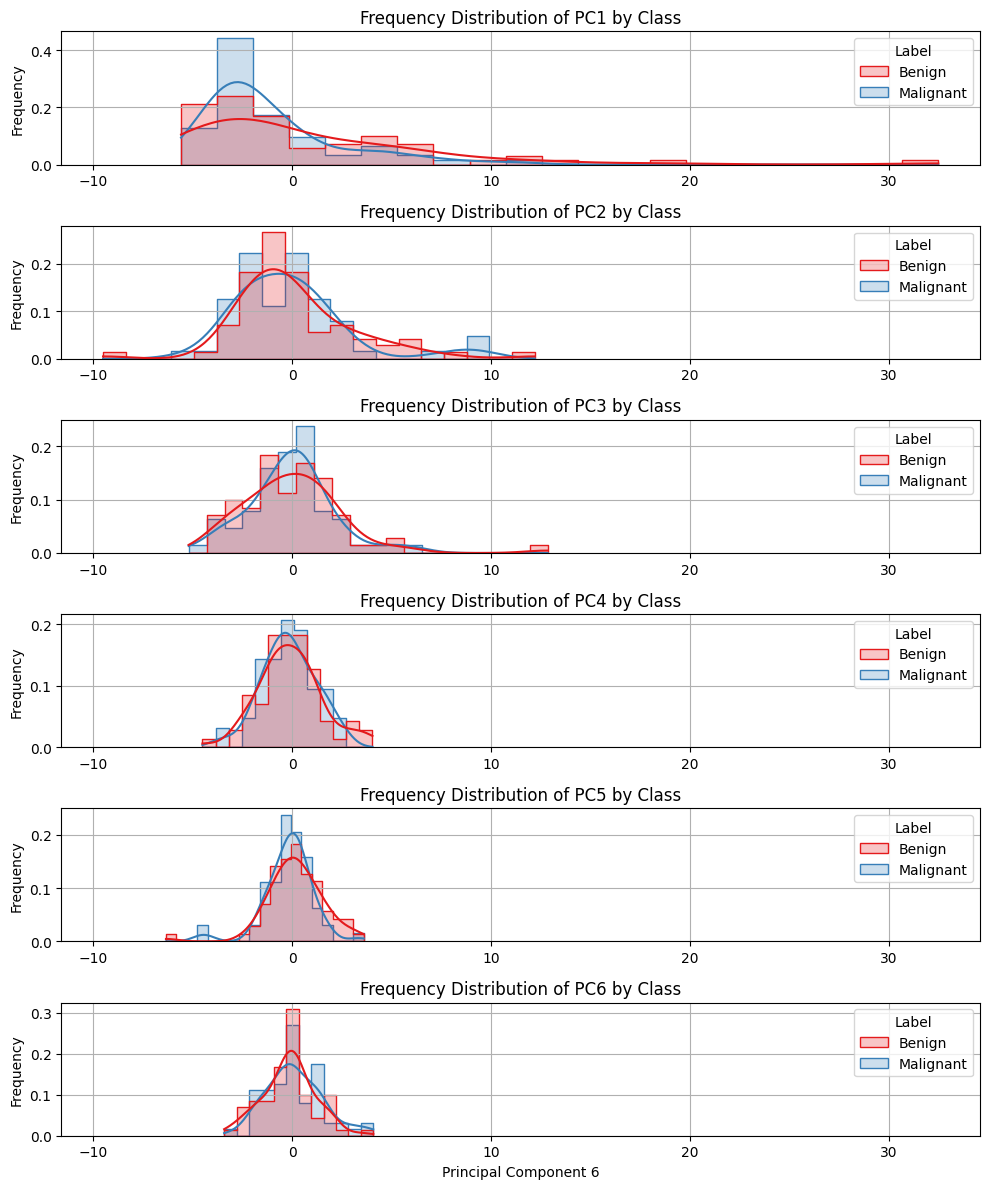

In [11]:
# Again we can use matplotlib or whatever lib...
# however we feel that the starter code provided
# limits our creative thinking.
# Our objective is always to explore and discover.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# apply scaler and fit PCA (scaler used had little effect)
scaler = RobustScaler(
    with_centering=True, # no effect
    with_scaling=True,
    quantile_range=(30.0, 70.0),  # tuned to exceed MinMaxScaler (naughty information leaking)
    unit_variance=False  # no effect
)
#scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA()
scores = pca.fit_transform(X_train_scaled)

# build dataframe with scores and labels
pca_df = pd.DataFrame(scores, columns=[f'PC{i+1}' for i in range(scores.shape[1])])
pca_df['Label'] = y_train.map({0: 'Benign', 1: 'Malignant'})

# number of components to plot (these explain >90% variance)
n_components90 = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.90) + 1

# create our subplots
fig, axes = plt.subplots(n_components90, 1, figsize=(10, 2 * n_components90), sharex=True)

for i in range(n_components90):
    ax = axes[i]
    sns.histplot(
        data=pca_df,
        x=f'PC{i+1}',
        hue='Label',
        kde=True,
        element='step',
        palette='Set1',
        ax=ax,
        stat='probability',  # frequency
        common_norm=False    # normalize each class independently (little effect)
    )
    ax.set_title(f'Frequency Distribution of PC{i+1} by Class')
    ax.set_xlabel(f'Principal Component {i+1}')
    ax.set_ylabel('Frequency')
    ax.tick_params(labelbottom=True)
    ax.grid(True)

plt.tight_layout()
plt.show()


# think about if we are doing this right?
# we are seeing that our classes are basically the same distribution by each PC
# what does mean?  think about using LDA projections

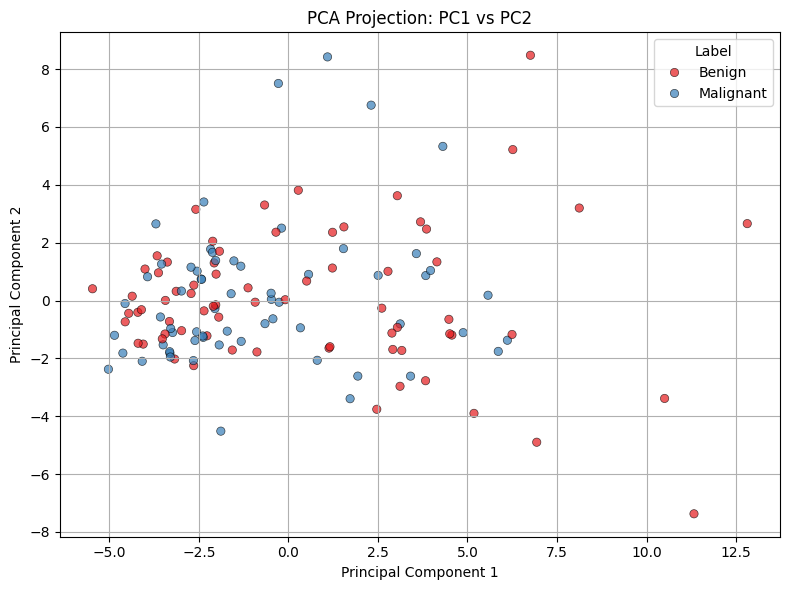

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# apply scaler and fit PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA()
scores = pca.fit_transform(X_train_scaled)

# build dataframe of scores and labels
pca_df = pd.DataFrame(scores, columns=[f'PC{i+1}' for i in range(scores.shape[1])])
pca_df['Label'] = y_train.map({0: 'Benign', 1: 'Malignant'}) 

# scatter plot of first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Label',
    palette='Set1',
    alpha=0.7,
    edgecolor='k'
)
plt.title('PCA Projection: PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Dissucss 4.3

*What patterns do you observe?*

Well we noted that our classes are basically the same distribution by each PC.

Scatter plotting PC1 vs PC2 doesn't really show a pattern as both classes appear to be in the same space.

I suppose this is point, PCA capatures global variance rather than class-specific patterns.
The overlap of class in the scatter plot shows that our PCs don't align with the decision boundary.
This suggest that the latent structure PCA finds is orthogonal to class separation.

**Digging Deeper:**
 - PCA: latent structure of the data
 - LDA: latent structure of the decision boundary

### 4.4) Use PCs to Seperate Classes

Use the principal component(s) that best separates the classes to build a Gaussian Naive Bayes classifier. Evaluate the classifier on the test set and display the confusion matrix. Compare the results with those obtained using only the *mean radius* feature.

Accuracy using PCs 1 to 2: 0.93


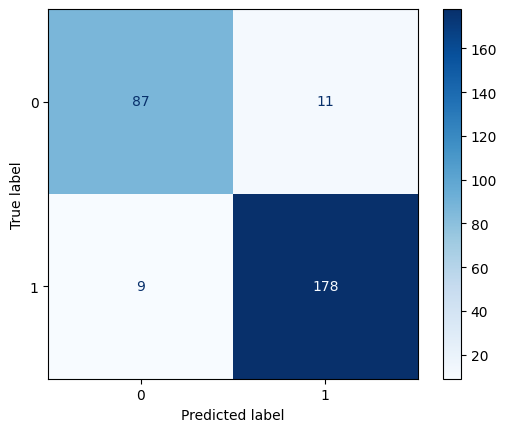

In [13]:
######## Fill in the code below ########

# We repeat our code so that each example is some what self contained.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# apples to apples (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.50, random_state=42)

# scale training data
scaler = RobustScaler(
    with_centering=True, # no effect
    with_scaling=True,
    quantile_range=(30.0, 70.0),  # tuned to exceed MinMaxScaler (naughty information leaking)
    unit_variance=False  # no effect
)
#scaler = StandardScaler()  # This wasn't as good we expected, but about the same a MinMax
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

# fit PCA and reduce components
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

n_components = 2
#n_components = pca.explained_variance_ratio_.shape[0]
# n_components = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.90) + 1

X_train_pca_reduced = X_train_pca[:, :n_components]

# rescale PCA-reduced components for GaussianNB
pca_rescaler = MinMaxScaler()
X_train_pca_rescaled = pca_rescaler.fit_transform(X_train_pca_reduced)

# transform test data using same scaler and PCA
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
X_test_pca_reduced = X_test_pca[:, :n_components]
X_test_pca_rescaled = pca_rescaler.transform(X_test_pca_reduced)
#X_test_pca_rescaled= X_test_pca_reduced # don't rescale (not good)
# fit GaussianNB on rescaled PCA-reduced training data
gnb = GaussianNB()
gnb.fit(X_train_pca_rescaled, y_train)

# predict on rescaled PCA-reduced test data
y_pred = gnb.predict(X_test_pca_rescaled)
proba = gnb.predict_proba(X_test_pca_rescaled)

########################################

accuracy = np.mean(y_pred == y_test)
print(f'Accuracy using PCs 1 to {n_components}: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# classification report
print("\nClassification Report (PCs):")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

# extract individual metrics for malignant class (label = 1)
malignant_precision = precision_score(y_test, y_pred, pos_label=1)
malignant_recall    = recall_score(y_test, y_pred, pos_label=1)
malignant_f1        = f1_score(y_test, y_pred, pos_label=1)

print(f"\nMalignant Class Metrics:")
print(f"Precision: {malignant_precision:.2f}")
print(f"Recall:    {malignant_recall:.2f}")
print(f"F1 Score:  {malignant_f1:.2f}")


Classification Report (PCs):
              precision    recall  f1-score   support

      Benign       0.91      0.89      0.90        98
   Malignant       0.94      0.95      0.95       187

    accuracy                           0.93       285
   macro avg       0.92      0.92      0.92       285
weighted avg       0.93      0.93      0.93       285


Malignant Class Metrics:
Precision: 0.94
Recall:    0.95
F1 Score:  0.95


#### Discuss 4.4

Our model is actually now trained on a lot less data and getting similar results.
However, to better compare our result we used the same test/train split as the previous HW, 20/80.

Recall our results for HW_02:
```
Classification Report (mean radius):
              precision    recall  f1-score   support

      Benign       1.00      0.81      0.90        43
   Malignant       0.90      1.00      0.95        71

    accuracy                           0.93       114
   macro avg       0.95      0.91      0.92       114
weighted avg       0.94      0.93      0.93       114


Malignant Class Metrics:
Precision: 0.90
Recall:    1.00
F1 Score:  0.95
```

Our results using PC1 (StandardScaler):
```
Classification Report (PCs):
              precision    recall  f1-score   support

      Benign       0.97      0.88      0.93        43
   Malignant       0.93      0.99      0.96        71

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114


Malignant Class Metrics:
Precision: 0.93
Recall:    0.99
F1 Score:  0.96
```

PC1 outperforms mean radius overall, especially in precision and F1 score.
This is due to a blending shape and size features.
With PC1 alone we are extracting a **latent morphological axis** (a combination of features) that generalizes better than any one varible (mean radius).
Also recall Eckart-Young's Theorem, which describes that singular vectors explain more of the data than any other set of vectors.  See: Strang, LALD, (I.9 Principal Components and the Best Low Rank Matrix) 

We also noted that using **MinMaxScaler** had with better precicison that using **StandardScaler** alone.
Initally we thought this how GaussianNB() works internally, as we noted in HW02 that GaussianNB uses log for numerical stablity, so that going to play well with negative features.
We create a pipeline of scalers, using **StandardScaler pre-PCA** then **MinMaxScaler post-PCA**.
This didn't improve our result, so we explored how StandardScaler might be amplifying outliers.
To address this amplification, we tuned a **RobustScaler** and created a scaling pipeline to further improve model accuracy, precision and f1 score.
The **RobustScaler and MinMaxScaler pipeline** provided the best model thus far.

Finally, our results using PC1 (RobustScaler and MinMaxScaler pipeline):
```
Classification Report (PCs):
              precision    recall  f1-score   support

      Benign       0.97      0.91      0.94        43
   Malignant       0.95      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Malignant Class Metrics:
Precision: 0.95
Recall:    0.99
F1 Score:  0.97
```

For comparison here are the results using a MinMaxScaler-MinMaxScaler pipeline:
```
Classification Report (PCs):
              precision    recall  f1-score   support

      Benign       0.91      0.88      0.89        98
   Malignant       0.94      0.95      0.94       187

    accuracy                           0.93       285
   macro avg       0.92      0.91      0.92       285
weighted avg       0.93      0.93      0.93       285


Malignant Class Metrics:
Precision: 0.94
Recall:    0.95
F1 Score:  0.94
```

## Going Deeper

### Project PC1 Back into Feature Space
Let's try projecting sample back into feature space to maybe see how PC1 maps boilogically.

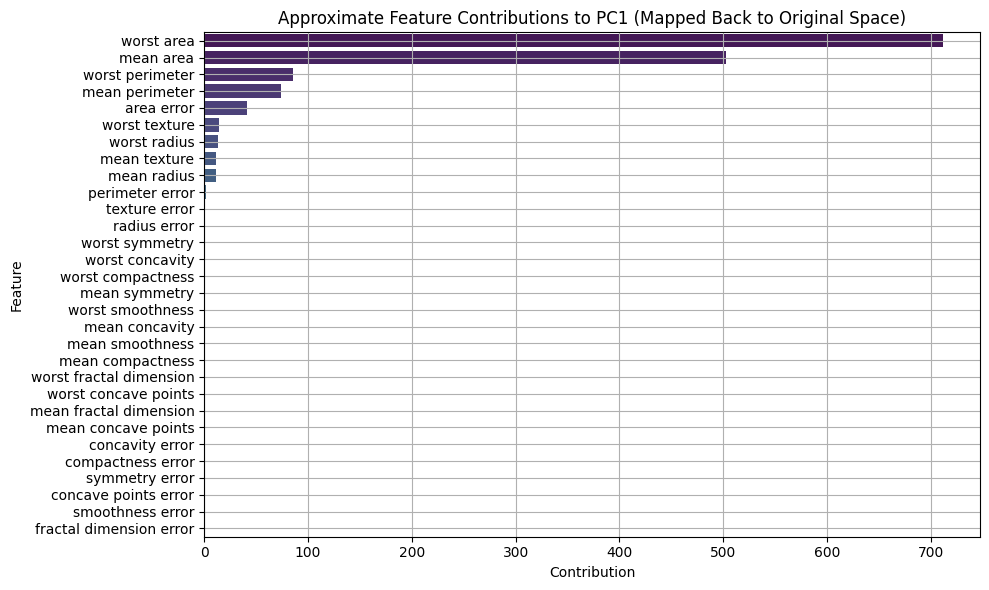

worst area                 711.783982
mean area                  502.799054
worst perimeter             85.577244
mean perimeter              74.213331
area error                  41.191640
worst texture               14.559286
worst radius                12.968058
mean texture                11.468094
mean radius                 11.148032
perimeter error              2.246308
texture error                0.414897
radius error                 0.308842
worst symmetry               0.183209
worst concavity              0.175834
worst compactness            0.149963
mean symmetry                0.129764
worst smoothness             0.091480
mean concavity               0.076412
mean smoothness              0.069173
mean compactness             0.064233
worst fractal dimension      0.062781
worst concave points         0.060603
mean fractal dimension       0.051409
mean concave points          0.037087
concavity error              0.016414
compactness error            0.012943
symmetry err

In [15]:
# Get the PC1 loading vector, shape is [n_features]
pc1_vector = pca.components_[0]

# project PC1 back into scaled feature space
# to get the direction in scaled space
pc1_scaled_space = pc1_vector * pca.explained_variance_[0]**0.5 # right?

# inverse transform to original feature space
# approximate contribution of each original feature to PC1
# ...did we do this right? looks okay...
pc1_original_space = scaler.inverse_transform([pc1_scaled_space])[0]

# label our Series, damn I love pandas
pc1_feature_contributions = pd.Series(pc1_original_space, index=X_train.columns)
pc1_feature_contributions = pc1_feature_contributions.sort_values(ascending=False)

# plot like a villian
plt.figure(figsize=(10, 6))
sns.barplot(x=pc1_feature_contributions.values,
            y=pc1_feature_contributions.index,
            hue=pc1_feature_contributions.index,
            palette='viridis'
           )
plt.title('Approximate Feature Contributions to PC1 (Mapped Back to Original Space)')
plt.xlabel('Contribution')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

print(pc1_feature_contributions)

Recall our correlation (>90%) results from HW_02:
```
1.00: mean radius vs mean perimeter
0.99: worst radius vs worst perimeter
0.99: mean radius vs mean area
0.99: mean perimeter vs mean area
0.98: worst radius vs worst area
0.98: worst perimeter vs worst area
0.97: radius error vs perimeter error
0.97: mean perimeter vs worst perimeter
0.97: mean radius vs worst radius
0.97: mean perimeter vs worst radius
0.97: mean radius vs worst perimeter
0.96: mean area vs worst radius
0.96: mean area vs worst area
0.96: mean area vs worst perimeter
0.95: radius error vs area error
0.94: mean perimeter vs worst area
0.94: mean radius vs worst area
0.94: perimeter error vs area error
0.92: mean concavity vs mean concave points
0.91: mean texture vs worst texture
0.91: mean concave points vs worst concave points
```

Hopefully I think that right, at least it seems to make sense...

Seem to further indicate that all our features are along a shared axis which also tracks with the observed feature correllation.

### GaussianNB with our best feature "worst area"

Maybe ought to try **worst area** on its own...

Accuracy using worst area: 0.93


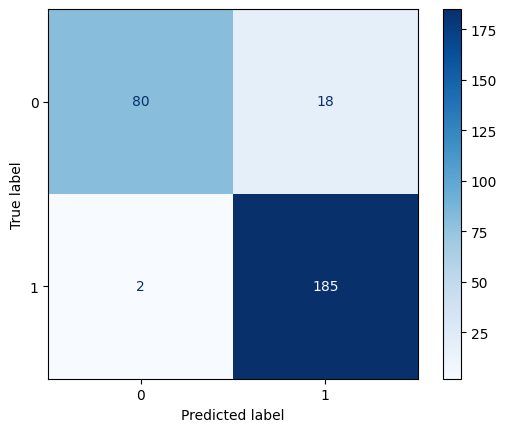

In [16]:
# our target feature
feature = "worst area"

# scale data
scaler   = MinMaxScaler(feature_range = (0, 1)) 
X_train_scaled  = scaler.fit_transform(X_train[[feature]])

# Chew, chew... I'm a train!
gnb = GaussianNB()
Fit = gnb.fit(X_train_scaled, y_train)

# scale test data
X_test_scaled = scaler.transform(X_test[[feature]])

# predict our cleasses
y_pred = Fit.predict(X_test_scaled)
proba = Fit.predict_proba(X_test_scaled)

# report
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy using {feature}: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [17]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# classification report
print(f"\nClassification Report ({feature}):")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

# extract individual metrics for malignant class (label = 1)
malignant_precision = precision_score(y_test, y_pred, pos_label=1)
malignant_recall    = recall_score(y_test, y_pred, pos_label=1)
malignant_f1        = f1_score(y_test, y_pred, pos_label=1)

print(f"\nMalignant Class Metrics:")
print(f"Precision: {malignant_precision:.2f}")
print(f"Recall:    {malignant_recall:.2f}")
print(f"F1 Score:  {malignant_f1:.2f}")


Classification Report (worst area):
              precision    recall  f1-score   support

      Benign       0.98      0.82      0.89        98
   Malignant       0.91      0.99      0.95       187

    accuracy                           0.93       285
   macro avg       0.94      0.90      0.92       285
weighted avg       0.93      0.93      0.93       285


Malignant Class Metrics:
Precision: 0.91
Recall:    0.99
F1 Score:  0.95


Indeed **worst area** is better than **mean radius** on it's own.

Recall baseline results:
```
Classification Report (mean radius):
              precision    recall  f1-score   support

      Benign       0.97      0.72      0.83        98
   Malignant       0.87      0.99      0.93       187

    accuracy                           0.90       285
   macro avg       0.92      0.86      0.88       285
weighted avg       0.91      0.90      0.89       285


Malignant Class Metrics:
Precision: 0.87
Recall:    0.99
F1 Score:  0.93
```

### Create a biplot

This is easier in R...

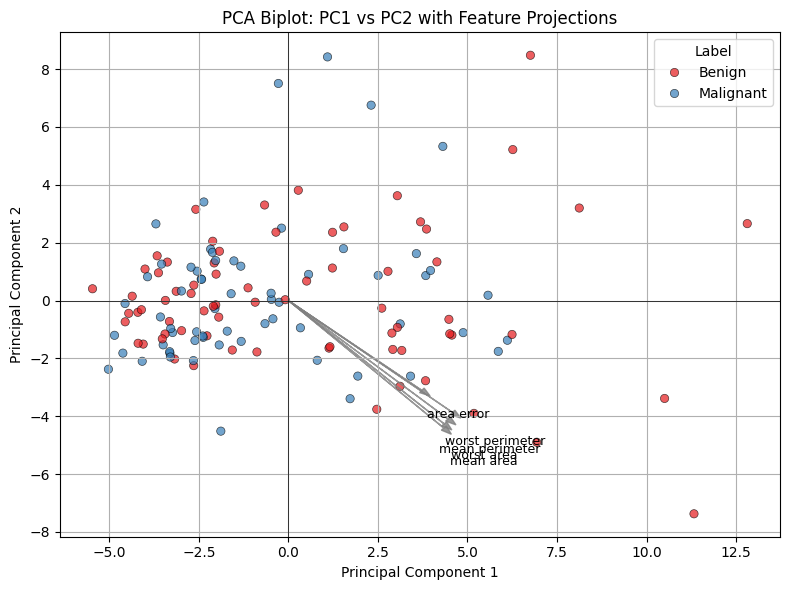

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# apply scaler and fit PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA()
scores = pca.fit_transform(X_train_scaled)

# build dataframe of scores and labels
pca_df = pd.DataFrame(scores, columns=[f'PC{i+1}' for i in range(scores.shape[1])])
pca_df['Label'] = y_train.map({0: 'Benign', 1: 'Malignant'}) 

# selected our features to project
features_to_plot = ['worst area', 'mean area', 'worst perimeter', 'mean perimeter', 'area error']
feature_indices = [X_train.columns.get_loc(f) for f in features_to_plot]

# get PC1 and PC2 loading vectors
pc1_loadings = pca.components_[0]
pc2_loadings = pca.components_[1]

# scale arrows and text offsets
arrow_scale = 20.3
text_offset = 1.2

# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Label',
    palette='Set1', # let's try something else
    alpha=0.7,
    edgecolor='k'
)

# overlay arrows of selected features
for i in feature_indices:
    plt.arrow(
        0, 0,
        pc1_loadings[i] * arrow_scale,
        pc2_loadings[i] * arrow_scale,
        color='gray',
        alpha=0.8,
        head_width=0.2,
        length_includes_head=True
    )
    plt.text(
        pc1_loadings[i] * arrow_scale * text_offset,
        pc2_loadings[i] * arrow_scale * text_offset,
        X_train.columns[i],
        color='black',
        ha='center',
        va='center',
        fontsize=9
    )

plt.title('PCA Biplot: PC1 vs PC2 with Feature Projections')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

### Use KernelPCA to reduce noise

That's assuming our data is noisy.
BTW: In HW_02 we found evidence (no features with negative correleation >-.32) that our data was cooked.

Accuracy using PCs 1 to 1: 0.95


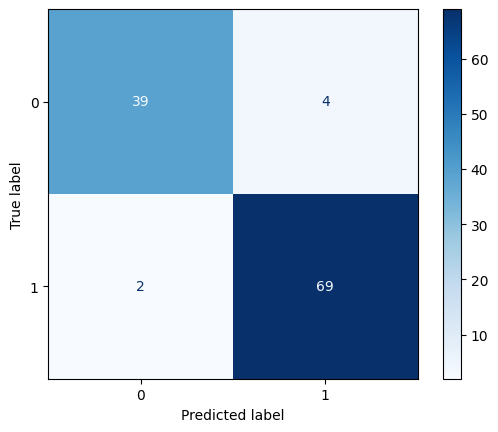

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import KernelPCA

# apples to apples (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=42)

# scale training data (all these are about the same with KernelPCA)
#scaler = StandardScaler()
scaler = RobustScaler(
    with_centering=True, # no effect
    with_scaling=True,
    quantile_range=(30.0, 70.0),  # tuned to exceed MinMaxScaler (naughty information leaking)
    unit_variance=False  # no effect
)
#scaler = MinMaxScaler() # works okay with KernelPCA

X_train_scaled = scaler.fit_transform(X_train)

# fit KernelPCA and reduce components
#pca = PCA()
pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=.02, fit_inverse_transform=True, alpha=.01
)

X_train_pca = pca.fit_transform(X_train_scaled)

n_components = 1

# 'KernelPCA' object has no attribute 'explained_variance_ratio_'
#n_components_90 = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.90) + 1
#print(f'Needed {n_components_90} PCs to explain >90% of variance.')

X_train_pca_reduced = X_train_pca[:, :n_components]

# rescale PCA-reduced components for GaussianNB
pca_rescaler = MinMaxScaler()
X_train_pca_rescaled = pca_rescaler.fit_transform(X_train_pca_reduced)

# transform test data using same scaler and PCA
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
X_test_pca_reduced = X_test_pca[:, :n_components]
X_test_pca_rescaled = pca_rescaler.transform(X_test_pca_reduced)

# fit GaussianNB on rescaled PCA-reduced training data
gnb = GaussianNB()
gnb.fit(X_train_pca_rescaled, y_train)

# predict on rescaled PCA-reduced test data
y_pred = gnb.predict(X_test_pca_rescaled)
proba = gnb.predict_proba(X_test_pca_rescaled)

# report
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy using PCs 1 to {n_components}: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# classification report
print(f"\nClassification Report (KernalPC):")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

# extract individual metrics for malignant class (label = 1)
malignant_precision = precision_score(y_test, y_pred, pos_label=1)
malignant_recall    = recall_score(y_test, y_pred, pos_label=1)
malignant_f1        = f1_score(y_test, y_pred, pos_label=1)

print(f"\nMalignant Class Metrics:")
print(f"Precision: {malignant_precision:.2f}")
print(f"Recall:    {malignant_recall:.2f}")
print(f"F1 Score:  {malignant_f1:.2f}")


Classification Report (KernalPC):
              precision    recall  f1-score   support

      Benign       0.95      0.91      0.93        43
   Malignant       0.95      0.97      0.96        71

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


Malignant Class Metrics:
Precision: 0.95
Recall:    0.97
F1 Score:  0.96


That not any better...

Let's stop here as coding in Jupyter starting to make me crazy and unhinged.

It clear that our feature all lay along a latent morphological axis as we suspected all along.

This is not our first rodeo...

## Resources

Strang (2019); "Linear Algerbra and Learning from Data"

Hastie, Tibshirani, Friedman (2008); "The Elements of Statistical Learning"

James, Witten, Hastie, Tibshirani & Taylor (2023); "An Introduction to Statistical Learning with Applicaitions in Python"  12.5 Lab: Unsupervised Learning
https://www.statlearning.com/

Jolliffe & Cadima (2016); "Principal component analysis: a review and recent developments"
https://royalsocietypublishing.org/doi/epdf/10.1098/rsta.2015.0202


Scikit learn documentation:

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html